# Initial Processes
## Importing Packages

In [1]:
#import packages
import numpy as np
import xarray as xr # deal with large arrays
import matplotlib.pyplot as plt # plot graphs
import pandas as pd # deal with datasets
import pygmt # to plot things on maps
from convertbng.util import convert_lonlat #, convert_bng # converting coordinates
import xrft # for padding grids
from magnetic_field_calculator import MagneticFieldCalculator # for getting value of local field

# fatiando libraries
import harmonica as hm 
import verde as vd

from matplotlib import rcParams
rcParams["figure.dpi"] = 130 #make figures larger

## Importing the dataset using `pandas`

In [2]:
data = pd.read_csv('aeromag.csv')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_28564/1919691400.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('aeromag.csv')


## Defining the limits of the investigation and extended limits of data analysis
Extending limits will reduce aliasing effects toward the edge of the region of interest. 

In [3]:
en = ([152207.0, 173499.0], [725285.0, 738732.0])

#adding 
extend = 30e3 #value to extend eastings and northings by, in metres

# Values to add to each number
additions = [[-extend, extend], [-extend, extend]] # what to add to each value

# Extending the region
updated_en = tuple(
    [en[i][j] + additions[i][j] for j in range(len(en[i]))] for i in range(len(en))
)

w_original = en[0][0]
e_original = en[0][1]
s_original = en[1][0]
n_original = en[1][1]
# storing the original easting northing limits (in metres)

eastings_d, northings_d = updated_en # storing updated easting northing limits, in metres

region_deg_ext = (eastings_d,northings_d)

region_deg = region_deg_ext[0] + region_deg_ext[1] # creating a new variable which is usable to define a region with Verde

region_deg_of_interest = en[0] + en[1]

inside = vd.inside((data.GRID_EAST,data.GRID_NORTH),
                   region_deg) # defining a filter with Verde

inside_of_interest = vd.inside((data.GRID_EAST,data.GRID_NORTH),
                   region_deg_of_interest)

In [4]:
DataZoom = data[inside] # filtering the data to include only those points within the extended region
Data_of_interest = data[inside_of_interest]

lat = DataZoom["GRID_NORTH"].astype('float') # northing
long = DataZoom["GRID_EAST"].astype('float') # easting
elev = DataZoom["AOD"].astype('float') # elevation of data

Mag_Anomaly = DataZoom.MAG_IGRF55 # Magnetic anomaly calculated from IGRF 1955 (likely that used by Bott & Tantrigoda, 1987)

lat_interest = Data_of_interest["GRID_NORTH"].astype('float') # northing
long_interest = Data_of_interest["GRID_EAST"].astype('float') # easting
elev_interest = Data_of_interest["AOD"].astype('float') # elevation of data

Mag_Anomaly_interest = Data_of_interest.MAG_IGRF55 # Magnetic anomaly calculated from IGRF 1955 (likely that used by Bott & Tantrigoda, 1987)

region = vd.get_region((eastings_d, northings_d)) # Defining a readable region for the extended region to be analysed

region_of_interest = vd.get_region(en)

coordinates = (long,lat,elev) # bringing coordinates together for use later
coordinates_of_interest = (long_interest,lat_interest,elev_interest) # bringing coordinates together for use later

## Plotting raw data on a map

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


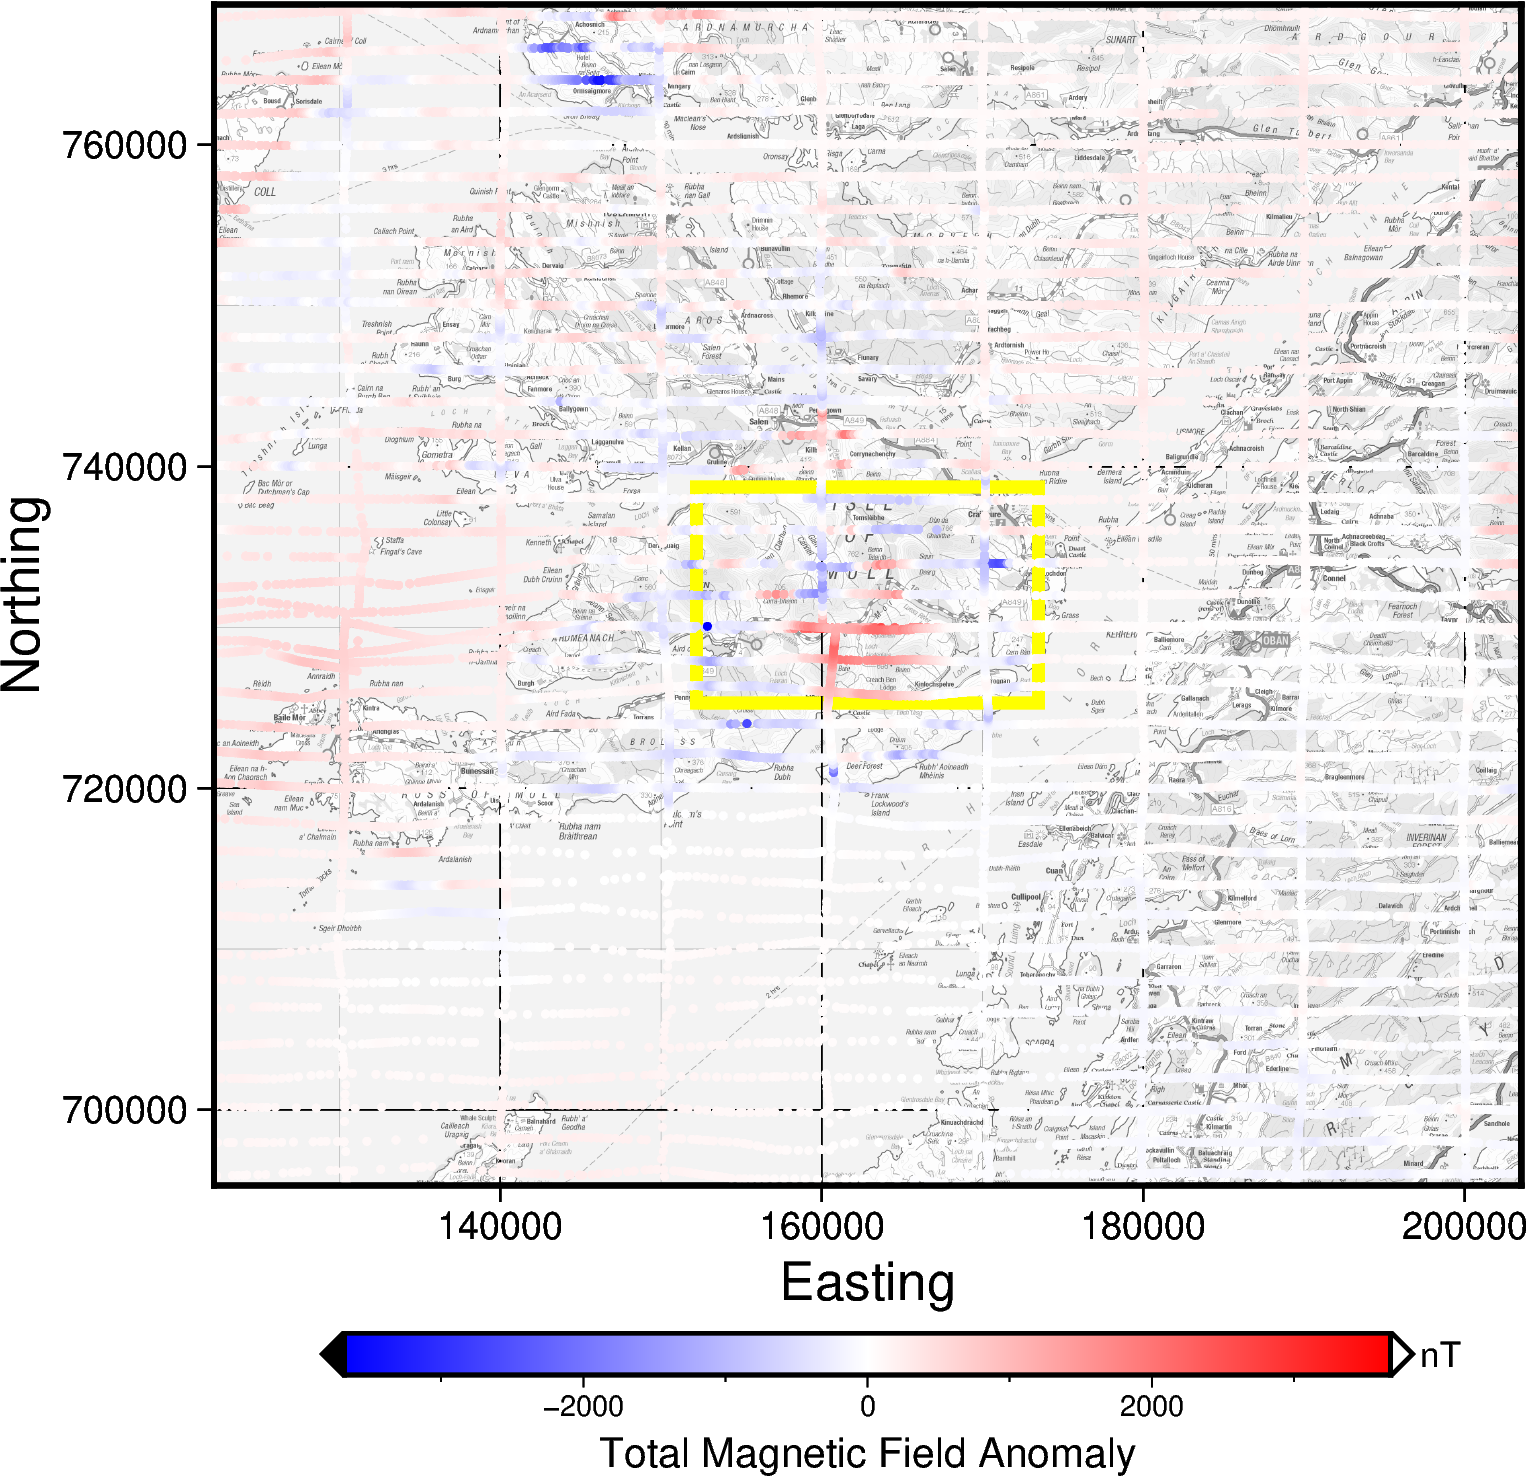

In [5]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"
maxabs = vd.maxabs(Mag_Anomaly) # Maximum value of magnetic anomaly

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])

with pygmt.config(FONT_TITLE="14p"):

   fig.grdimage(
      grid = "Mull.tif",
      dpi = 300,
      region = region,
      frame=['ag'],
      projection=fig_proj,
      monochrome = True,
      transparency = 30
   )

   fig.plot(data=np.array([[e_original,s_original,w_original,n_original]]), style='r+s', pen="3p,yellow")
   
   fig.plot(
      x=long,
      y=lat,
      fill=Mag_Anomaly,
      cmap=True,
      style="c2p",
      projection=fig_proj,
      region=region,
      frame=['ag', "xaf+lEasting", "yaf+lNorthing"]
   )
   fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a2000f1000", "x+lTotal Magnetic Field Anomaly", "y+lnT"])

fig.savefig("Mag_Data.pdf")
fig.show()

## Creating an Equivalent Layer

Equivalent layers require Cartesian coordinates to be generated, hence why easting northing coordinates have been used instead of latitude and longitude.

Here, block averaging is being used, since the aeromagnetic data are highly oversampled along flight lines.

In [6]:
print('Number of data points: ',np.shape(coordinates)[1])

Number of data points:  24077


In [7]:
# block_size: should be smaller than desired resolution of grid (0.5km, as per Smith & Royles, 1987) 

eql = hm.EquivalentSources(damping=0.01, # can change (removes artifacts by smoothing coefficients of equivalent layer)
                           depth=500, # 500m depth
                           block_size = 200 # since the resolution is around 500m
                          )

eql.fit(coordinates, Mag_Anomaly)
print(eql.points_[0].size)

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x111b79800> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x111b79800> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


12308


### Check whether the equivalent layer can predict the true values

In [8]:
anomaly = eql.predict(coordinates)

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


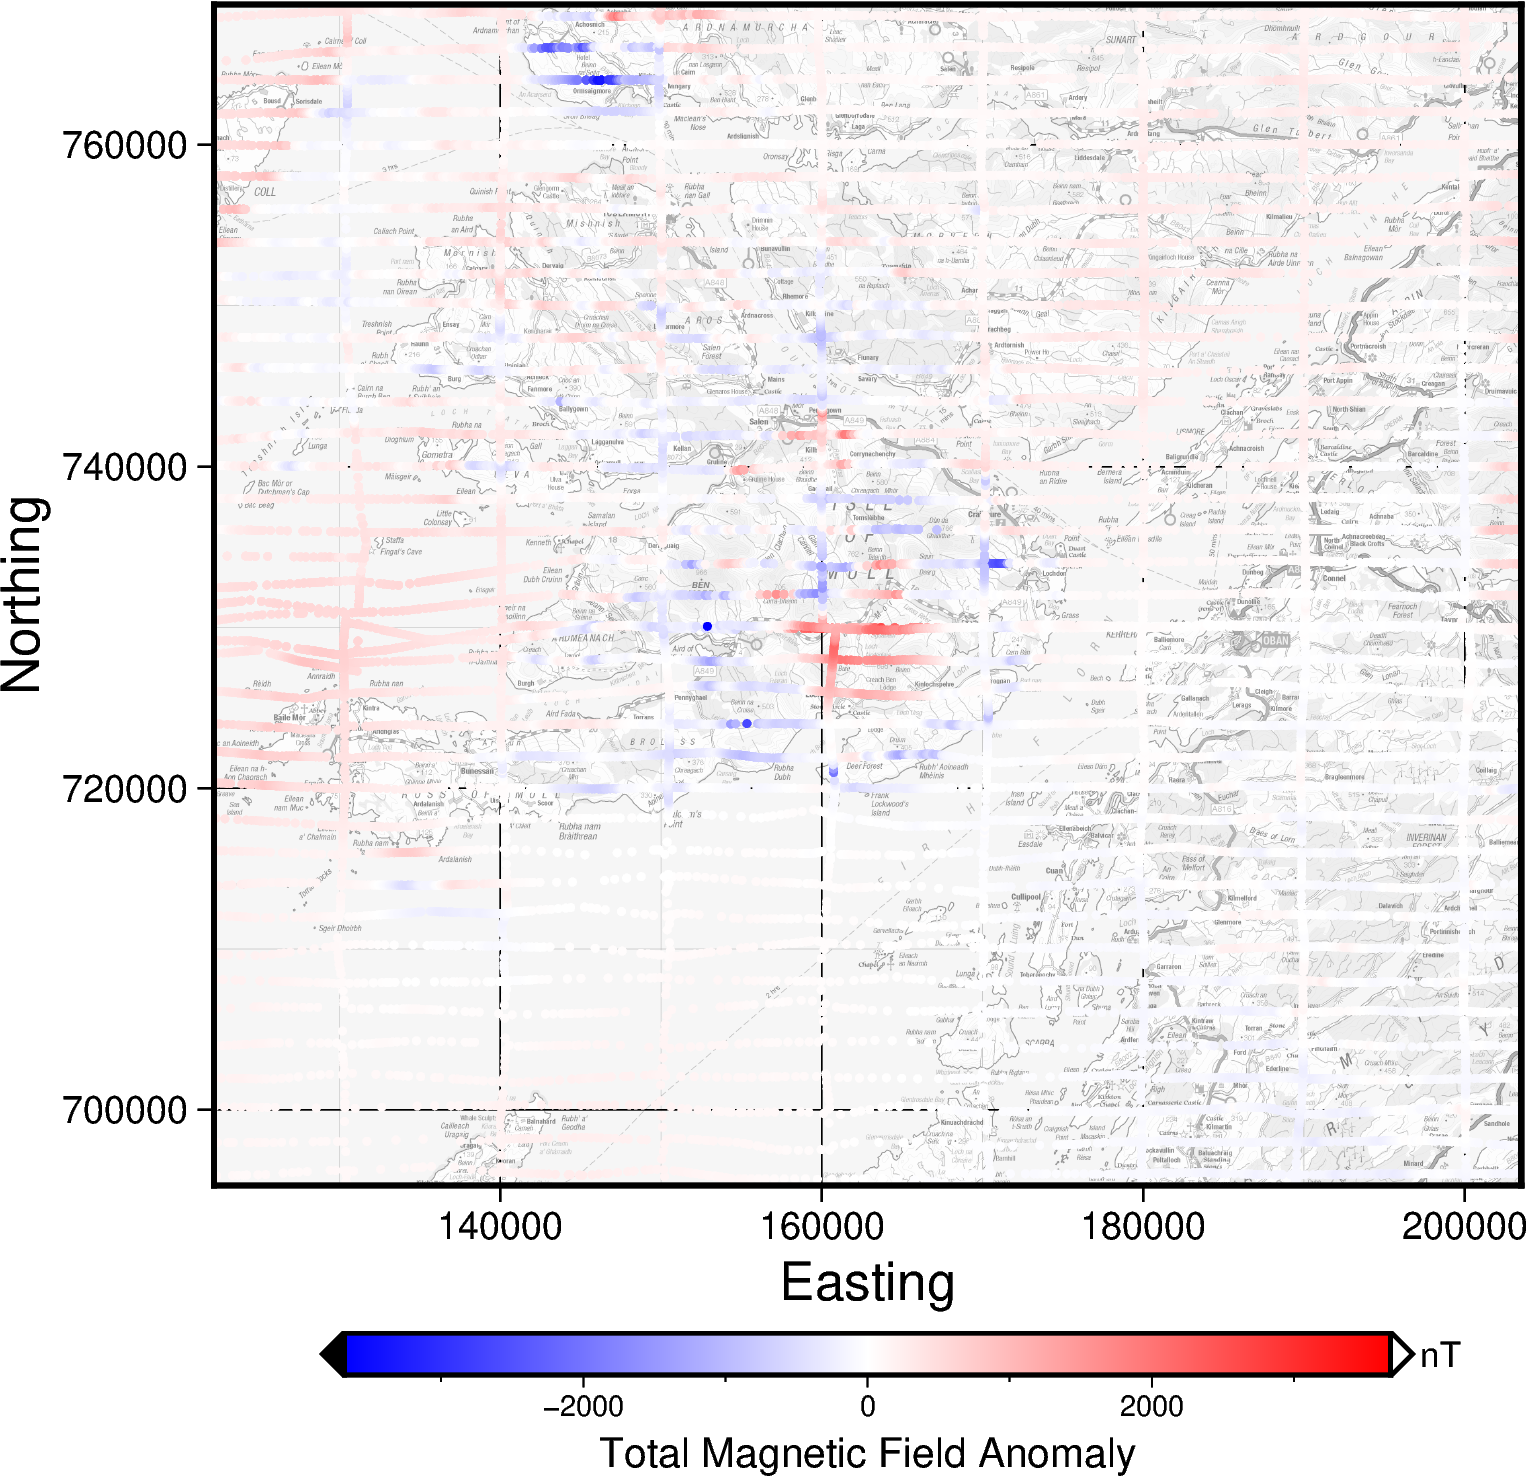

In [9]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

fig = pygmt.Figure()

pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
with pygmt.config(FONT_TITLE="14p"):
      fig.grdimage(
            grid = "Mull.tif",
            dpi = 300,
            region = region,
            projection=fig_proj,
            monochrome = True,
            transparency = 50
         )

      fig.plot(
         x=long,
         y=lat,
         fill=Mag_Anomaly,
         cmap=True,
         style="c2p",
         frame=["ag","xaf+lEasting", "yaf+lNorthing"],
         transparency = 0
      )
      fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a2000f1000", "x+lTotal Magnetic Field Anomaly", "y+lnT"])

fig.savefig("EQL_Test_Aeromag.pdf")
fig.show()

## Creating a Grid

In [10]:
print('Maximum height: ',elev.max(),'m') # printing the maximum elevation, giving an estimate for upward-continuing the data

Maximum height:  992.0 m


In [11]:
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=500, # Resolution of 500km
    extra_coords=1.5e3, # Above the maximum height, meaning data are also upward-continued
)

grid = eql.grid(grid_coords, data_names=["magnetic_anomaly"],
                dim=("northing","easting")
                ) # gridding the data

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/harmonica/_equivalent_sources/cartesian.py:460: FutureWarning: The 'dim' arguments are being ignored. The 'grid' method will not take any keyword arguments in the next Harmonica release
  warnings.warn(


In [12]:
# Create a new DataArray, keeping the existing coordinates
grid_DataArray = xr.DataArray(
    data=grid['magnetic_anomaly'].values,
    coords={
        'northing': grid['northing'],
        'easting': grid['easting'],
        'upward': grid['upward']  # Assuming 'upward' is part of the dataset
    },
    dims=['northing', 'easting']
)

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


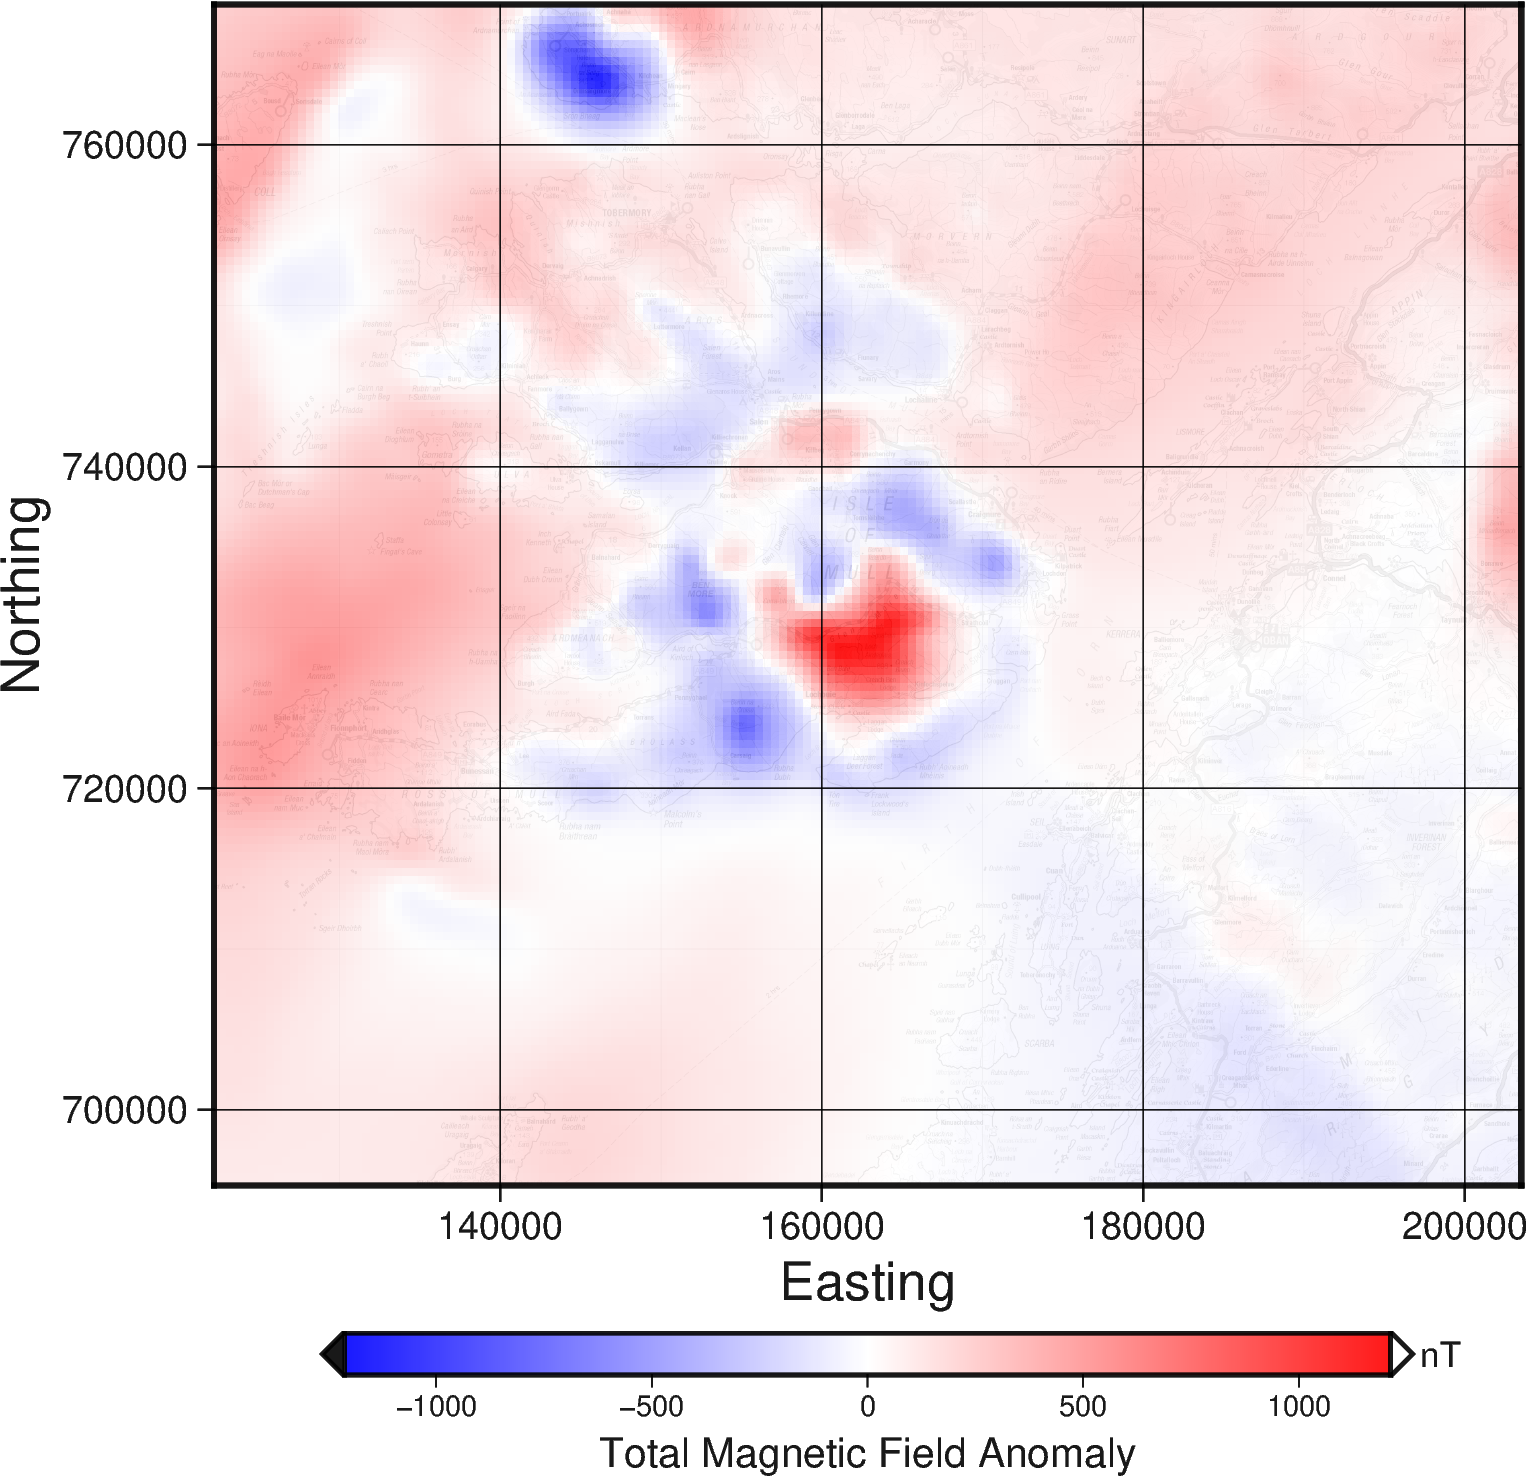

In [22]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"
maxabs = vd.maxabs(grid.magnetic_anomaly)
fig = pygmt.Figure()

pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
with pygmt.config(FONT_TITLE="14p"):
   fig.grdimage(
         grid = "Mull.tif",
         dpi = 300,
         region = region,
         projection=fig_proj,
         monochrome = True,
         transparency = 0
      )

   fig.grdimage(
      grid=grid.magnetic_anomaly,
      cmap=True,
      transparency = 10,
      frame=["ag","xaf+lEasting", "yaf+lNorthing"]
   )
   fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a500f500", "x+lTotal Magnetic Field Anomaly", "y+lnT"],
                  transparency = 10
                  )

fig.savefig("Gridding_Aeromag.pdf")
fig.show()

## Add Padding before Reduction to the Pole Grid Transformation

In [17]:
pad_width = {
    "easting": grid_DataArray.easting.size // 3,
    "northing": grid_DataArray.northing.size // 3,
}
magnetic_grid_no_height = grid_DataArray.drop_vars("upward")
magnetic_grid_padded = xrft.pad(magnetic_grid_no_height, pad_width)

## Reduction to the Pole

### Find the magnetic field vectors

In [18]:
####Update this if not using IGRF 1955
calculator = MagneticFieldCalculator(
    model='igrf'
)
calculator

In [19]:
longitude, latitude = convert_lonlat(eastings_d,northings_d)

lat_ts = np.mean(latitude)
long_ts = np.mean(longitude)
elev_ts = elev.values.mean()

result = calculator.calculate(
    latitude=lat_ts,
    longitude=long_ts,
    altitude=elev_ts,
    date='1963-01-01'
)

In [20]:
declination = result['field-value']['declination']['value']
inclination = result['field-value']['inclination']['value']
total_field = result['field-value']['total-intensity']['value']
print('Dec: ',declination,'º')
print('Inc: ',inclination,'º')
print('Total Field Anomaly: ',total_field,'nT')

Dec:  -12.069 º
Inc:  70.251 º
Total Field Anomaly:  40911 nT


### Performing the RTP

In [21]:
rtp_grid = hm.reduction_to_pole(
    magnetic_grid_padded, inclination=inclination, declination=declination
)

# Unpad the reduced to the pole grid
rtp_grid = xrft.unpad(rtp_grid, pad_width)

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


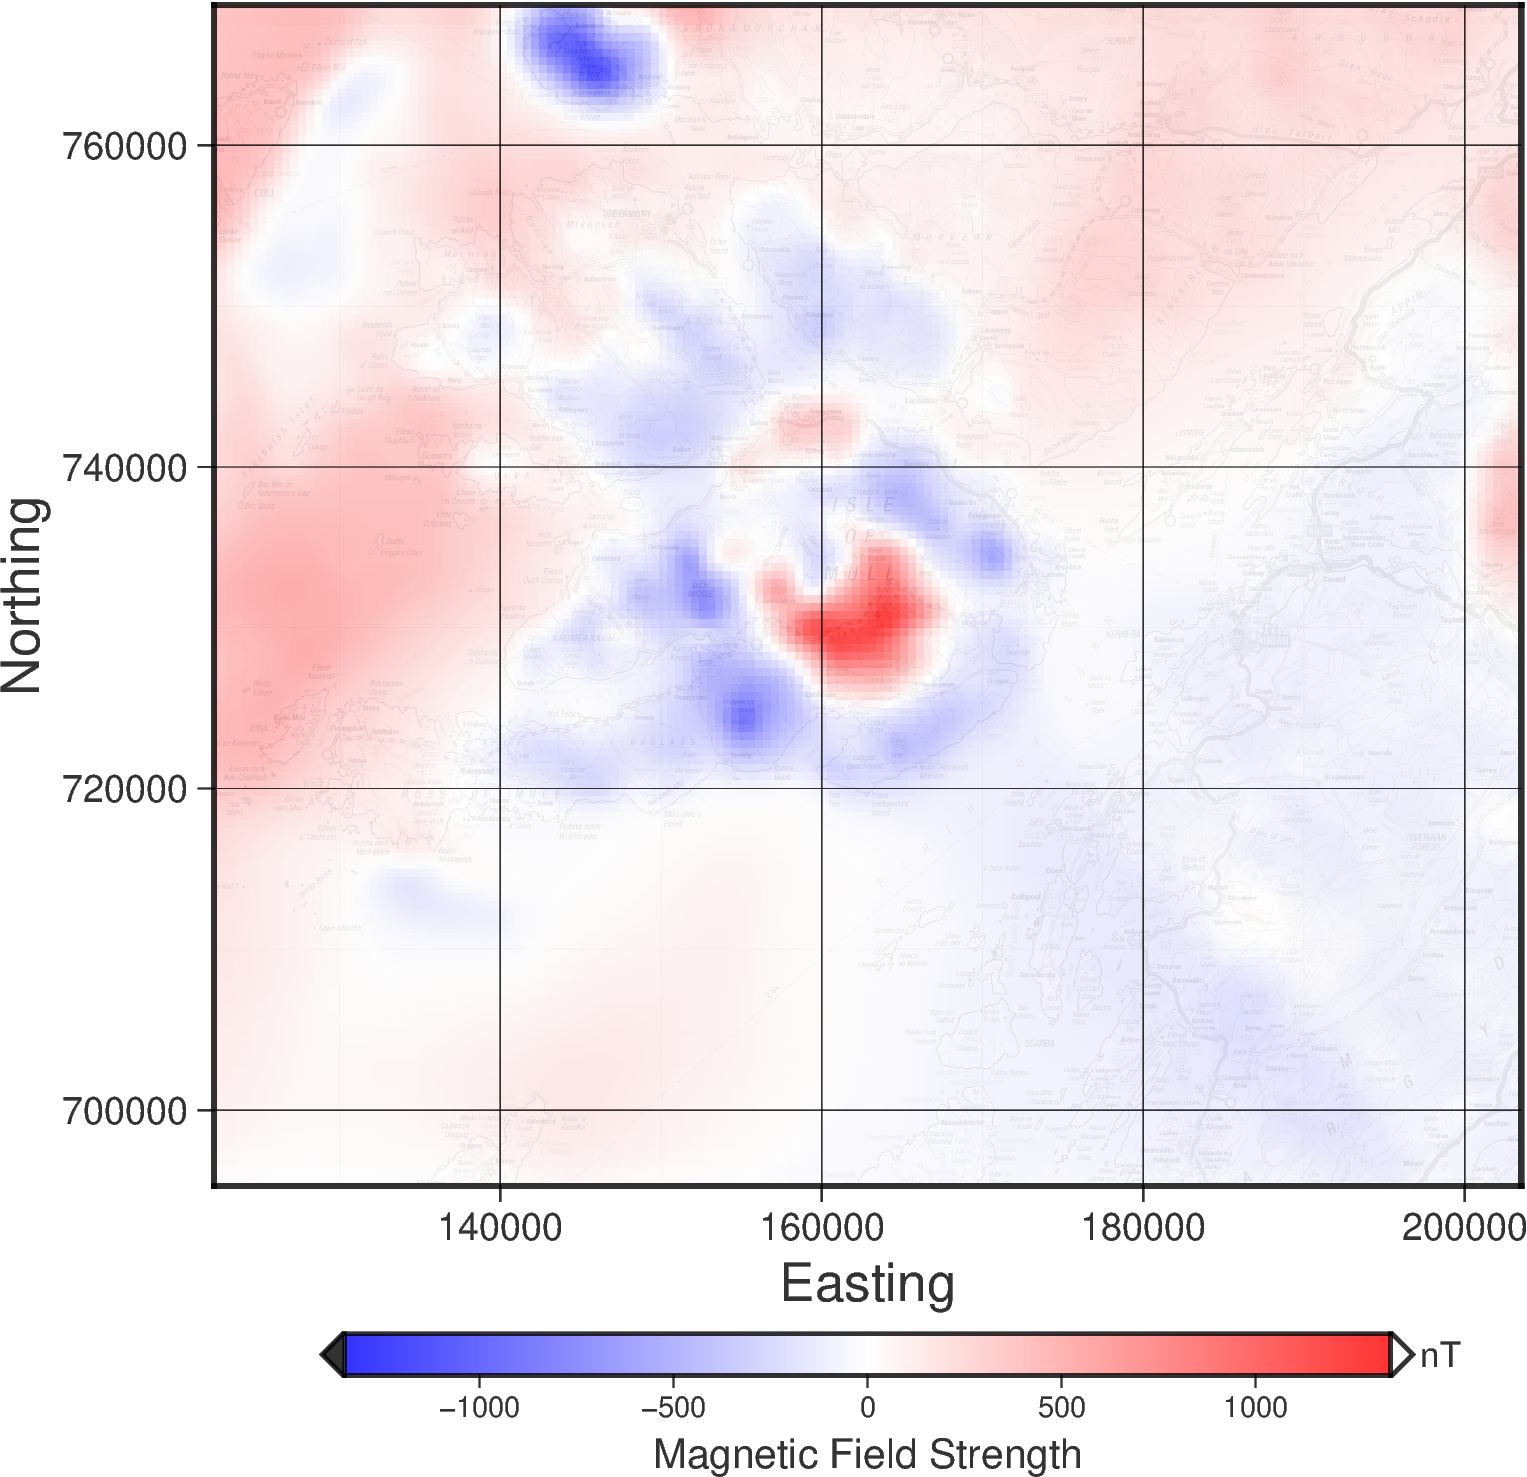

In [27]:
fig = pygmt.Figure()

maxabs = vd.maxabs(rtp_grid.values)+100 # ensuring that no white squares appear at the maximum

pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
with pygmt.config(FONT_TITLE="14p"):
      fig.grdimage(
            grid = "Mull.tif",
            dpi = 300,
            region = region,
            projection=fig_proj,
            monochrome = True,
            transparency = 50
         )

      fig.grdimage(grid=rtp_grid, 
                   cmap=True, 
                   transparency = 20,
                   frame=["ag","xaf+lEasting", "yaf+lNorthing"])
      
      fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a500f500", "x+lMagnetic Field Strength", "y+lnT"],
                   transparency = 20)
fig.savefig("RTP_Check.pdf")
fig.show()

# Taking a profile

In [28]:
eastings_profile = [149007.5694,176972.2456]
northings_profile = [744637.9853,715047.2193]

#filter out those parts of the profile outside the area of interest
def distance_to_a(x1, y1, x2, y2, ya):
    # Gradient
    m = (y2 - y1) / (x2 - x1)

    c = y1-m*x1

    xa = (ya-c)/m

    distance = np.sqrt((x1-xa)**2+(y1-ya)**2)/1e3 # converting to km

    return distance
start = ([eastings_profile[0],northings_profile[0]])
end = ([eastings_profile[1],northings_profile[1]])

print(n_original)
print(s_original)
end_profile = distance_to_a(eastings_profile[0], northings_profile[0], eastings_profile[1], northings_profile[1],s_original) #bottom region
print(end_profile)
start_profile = distance_to_a(eastings_profile[0], northings_profile[0], eastings_profile[1], northings_profile[1],n_original) #top region
print(start_profile)

738732.0
725285.0
26.62786925205381
8.126074708120104


In [29]:
#rtp_grid_new = rtp_grid.to_dataset(name='magnetic_anomaly')
rtp_grid_table = vd.grid_to_table(rtp_grid)

In [30]:
rtp_grid_table_profile = rtp_grid_table[(rtp_grid_table.easting > eastings_profile[0]) & (rtp_grid_table.easting < eastings_profile[1])]
rtp_grid_table_profile = rtp_grid_table_profile[(rtp_grid_table.northing > northings_profile[1]) & (rtp_grid_table.northing < northings_profile[0])]

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_28564/4064106653.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rtp_grid_table_profile = rtp_grid_table_profile[(rtp_grid_table.northing > northings_profile[1]) & (rtp_grid_table.northing < northings_profile[0])]


In [31]:
spline = vd.SplineCV(
    dampings=(1e-10,1e-05,0.01,0.1,1)
) #testing a number of damping parameters before the best is identified 

spline.fit(
    (rtp_grid_table_profile.easting,rtp_grid_table_profile.northing),
    data = rtp_grid_table_profile.scalars
)

profile= spline.profile(
    start,
    end,
    size=500,
    data_names = ["mag_anomaly"],
 	dims = ("latitude","longitude")
)

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/spline.py:245: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  spline = Spline(**params)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/sklearn/base.py:125: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  new_object = klass(**new_object_params)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.37546e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/model_selection.py:784: FutureWarning: The default scoring will change from R²

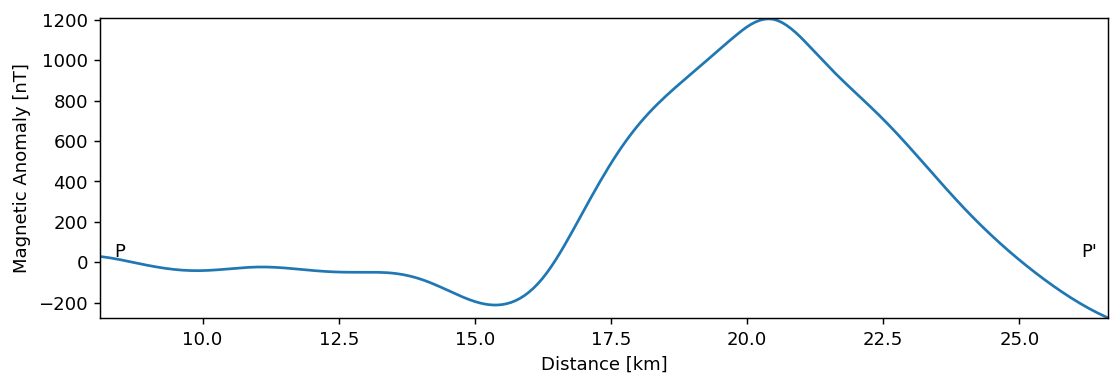

In [32]:
interest = (start_profile*1e3 < profile.distance) & (profile.distance < end_profile*1e3)
interest_disturbance = profile.mag_anomaly[interest]

fig,ax = plt.subplots()

ax.plot(profile.distance/1000,profile.mag_anomaly)

fig.set_size_inches(10,3)
ax.set_xlim(start_profile,end_profile)
ax.set_ylim(min(interest_disturbance)-5,max(interest_disturbance)+5)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnetic Anomaly [nT]")
ax.annotate("P", xy=(start_profile+0.25,25))
ax.annotate("P'", xy=(end_profile-0.5,25))
plt.show()

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


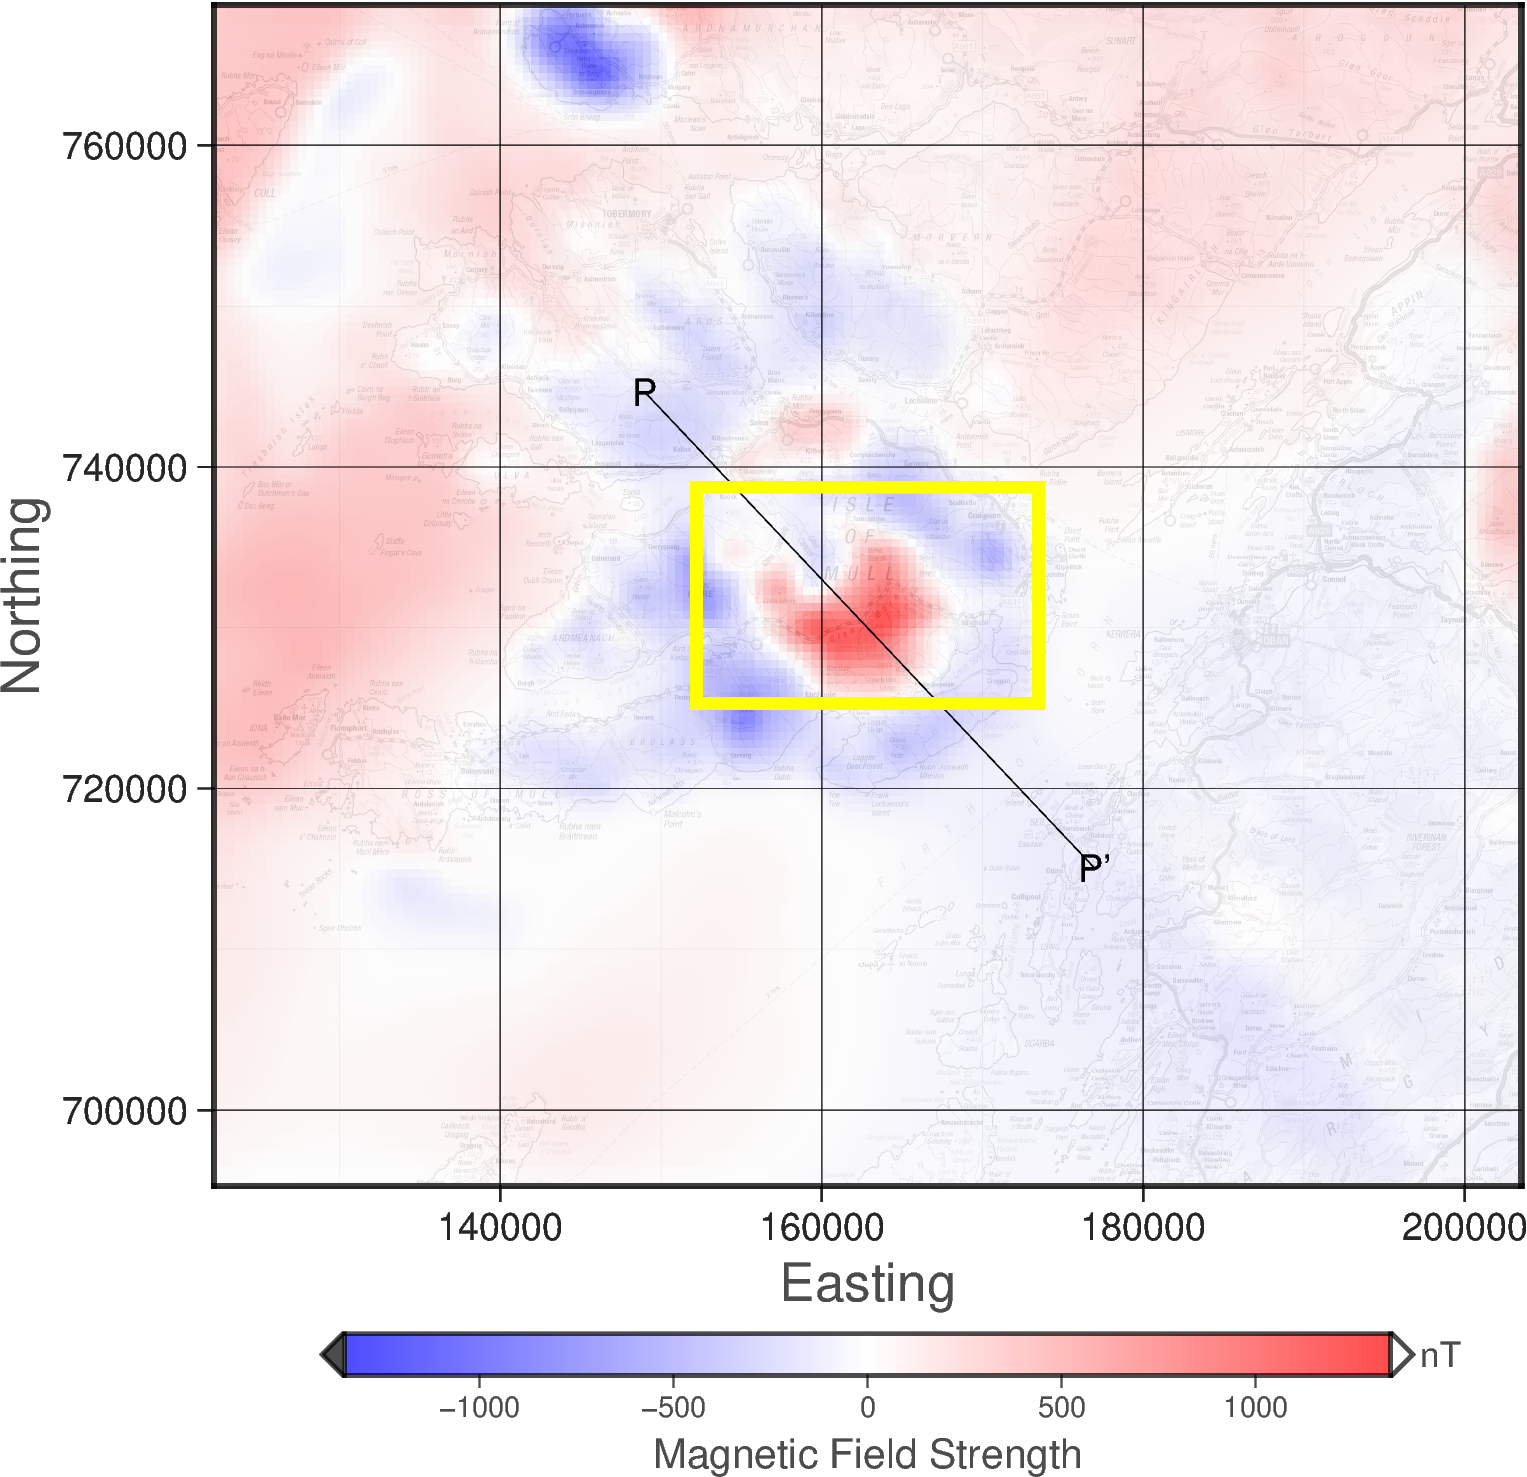

In [33]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"
maxabs = vd.maxabs(rtp_grid.values)+100
x = [p[0] for p in (start, end)]
y = [p[1] for p in (start, end)]

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])

with pygmt.config(FONT_TITLE="14p"):

   fig.grdimage(
      grid = "Mull.tif",
      dpi = 300,
      region = region,
      frame=['ag'],
      projection=fig_proj,
      monochrome = True,
      transparency = 50
   )

   fig.grdimage(
        grid=rtp_grid,
        cmap=True,
        projection=fig_proj,
        transparency = 30,
        frame=["ag","xaf+lEasting", "yaf+lNorthing"]
      )
   fig.plot(x=x, y=y)

   fig.plot(data=np.array([[e_original,s_original,w_original,n_original]]), style='r+s', pen="3p,yellow")

   fig.text(text=["P", "P'"], x=[start[0], end[0]], y=[start[1]-0.02, end[1]-0.02])
   
   fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a500f500", "x+lMagnetic Field Strength", "y+lnT"],
                   transparency = 30)

fig.savefig("RTP_with_Cross_Section.pdf")
fig.show()

In [34]:
grid_table = vd.grid_to_table(grid)

In [35]:
grid_table_profile = grid_table[(grid_table.easting > eastings_profile[0]) & (grid_table.easting < eastings_profile[1])]
grid_table_profile = grid_table_profile[(grid_table.northing > northings_profile[1]) & (grid_table.northing < northings_profile[0])]

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_28564/968380841.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grid_table_profile = grid_table_profile[(grid_table.northing > northings_profile[1]) & (grid_table.northing < northings_profile[0])]


In [36]:
spline_norm = vd.SplineCV(
    dampings=(1e-10,1e-05,0.01,0.1,1)
) #testing a number of damping parameters before the best is identified 

spline_norm.fit(
    (grid_table_profile.easting,grid_table_profile.northing),
    data = grid_table_profile.magnetic_anomaly
)

profile_norm= spline_norm.profile(
    start,
    end,
    size=500,
    data_names = ["mag_anomaly"],
 	dims = ("latitude","longitude")
)

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/spline.py:245: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  spline = Spline(**params)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/sklearn/base.py:125: FutureWarning: The mindist parameter of verde.Spline is no longer required and will be removed in Verde 2.0.0. Use the default value to obtain the future behavior.
  new_object = klass(**new_object_params)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.37546e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/model_selection.py:784: FutureWarning: The default scoring will change from R²

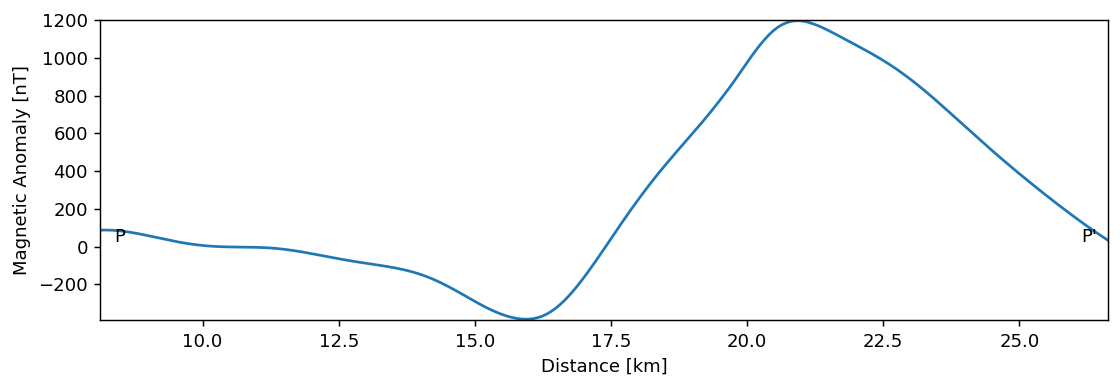

In [37]:
interest = (start_profile*1e3 < profile_norm.distance) & (profile_norm.distance < end_profile*1e3)
interest_disturbance = profile_norm.mag_anomaly[interest]

fig,ax = plt.subplots()

ax.plot(profile_norm.distance/1000,profile_norm.mag_anomaly)

fig.set_size_inches(10,3)
ax.set_xlim(start_profile,end_profile)
ax.set_ylim(min(interest_disturbance)-5,max(interest_disturbance)+5)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnetic Anomaly [nT]")
ax.annotate("P", xy=(start_profile+0.25,25))
ax.annotate("P'", xy=(end_profile-0.5,25))
plt.show()

In [38]:
norm_profile_array = np.column_stack((profile_norm.distance.values,profile_norm.mag_anomaly.values))
rtp_profile_array = np.column_stack((profile.distance.values,profile.mag_anomaly.values))

np.savetxt('norm_profile_array.txt',norm_profile_array)
np.savetxt('rtp_profile_array.txt',rtp_profile_array)